In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
from torch.autograd import Variable
from torch.linalg import multi_dot
import torch.optim as optim

In [ ]:
def henon_attractor(x, y, a, b):
	x_next = 1 - a * x ** 2 + y
	y_next = b * x
	return x_next, y_next

In [ ]:
def henon_attractor_iters(steps,a,b):
 X = np.zeros(steps + 1)
 Y = np.zeros(steps + 1)
 # starting point
 X[0], Y[0] = 0, 0

 # add points to array
 for i in range(steps):
  x_next, y_next = henon_attractor(X[i], Y[i],a,b)
  X[i+1] = x_next
  Y[i+1] = y_next

 return X,Y

In [ ]:
def henon_boundary(max_iterations, a, b):
  ''' A function to show the basin of attraction for
  the Henon map.  Takes in the desired number of maximum
  iterations and the a and b values for the Henon equation,
  returns an array of the number of iterations until divergence
  '''
  x_range = 2000
  y_range = 2000

  x_list = np.arange(-5, 5, 10/x_range)
  y_list = np.arange(5, -5, -10/y_range)
  array = np.meshgrid(x_list, y_list)

  x2 = np.zeros(x_range)
  y2 = np.zeros(y_range)
  iterations_until_divergence = np.meshgrid(x2, y2)

  for i in iterations_until_divergence:
    for j in i:
      j += max_iterations
  # make an array with all elements set to 'True'
  not_already_diverged = array[0] < 1000

  for k in range(max_iterations):
    array_copied = copy.deepcopy(array[0]) # copy array to prevent premature modification of x array

    # henon map applied to array
    array[0] = 1 - a * array[0]**2 + array[1]
    array[1] = b * array_copied

    # note which array elements are diverging but have not already diverged
    r = (array[0]**2 + array[1]**2)**0.5
    diverging = r > 10
    diverging_now = diverging & not_already_diverged
    iterations_until_divergence[0][diverging_now] = k
    not_already_diverged = np.invert(diverging_now) & not_already_diverged

    # prevent explosion to infinity
    array[0][diverging] = 0
    array[1][diverging] = 0

  return iterations_until_divergence[0]


Henon Attractor 1 step

Calcola il Jacobiano (grad su x e y)

Cicla sta cosa per poter calcolare la produttoria dei jacobiani a tempi diversi (batch lenght)

Calcola gli autovalori sulla produttoria e prendi il più grande

Calcola la derivata dell'esponente di lyapunov in funzione di a e b

aggiorna a e b e ricomincia sto ciclo




In [ ]:
import torch

torch.autograd.set_detect_anomaly(True)

a = torch.tensor(1.0, requires_grad=True)
learning_step_a = 0.001

b = torch.tensor(-0.2, requires_grad=True)
learning_step_b = 0.001

steps = 30
epochs = 1000

XY = torch.rand(steps + 1, 2,requires_grad=True)  # 2D vector to hold X and Y
Jacobian_seq = torch.zeros((steps, 2, 2))
Jacobian_prod = torch.zeros((steps, 2, 2))  # Initialize with the identity matrix

Lyapunov_seq = torch.zeros(epochs, requires_grad=False)
a_seq = torch.zeros(epochs, requires_grad=False)
b_seq = torch.zeros(epochs, requires_grad=False)

dLyapunov_da = torch.tensor(0.0, requires_grad=True)
dLyapunov_db = torch.tensor(0.0, requires_grad=True)

lim = None  # Initialize lim

# Define system equation outside the loop
def system_equation(x):
    return torch.tensor([
        1 - a * x[0] ** 2 + x[1],
        b * x[0]
    ])

print("\na=", a, "b=", b)
for j in range(0, epochs):
    a_seq[j] = a
    a = a + dLyapunov_da * learning_step_a
    b_seq[j] = b
    b = b + dLyapunov_db * learning_step_b
    Lyapunov_exponents_sum = 0
    for i in range(0, steps):
        # Henon Step
        XY[i + 1] = system_equation(XY[i])

        # Calculate Jacobian using torch.autograd.functional.jacobian
        Jacobian_seq[i] = torch.autograd.functional.jacobian(system_equation, XY[i])
        print("jacobian:", Jacobian_seq[i])

        # Compute eigenvalues for each Jacobian matrix
        Eigenvalues = torch.linalg.eigvals(Jacobian_seq[i])

        print("Eigenvalues shape:", Eigenvalues)

        # Compute Lyapunov exponents for each eigenvalue
        Lyapunov_exponents = (1 / steps) * torch.log(torch.abs(torch.max(Eigenvalues.real)))
        print(Lyapunov_exponents)
        Lyapunov_exponents_sum += Lyapunov_exponents/steps


    # Compute the mean Lyapunov exponent for this iteration
    Lyapunov_seq[j] = Lyapunov_exponents_sum

    if Lyapunov_seq[j] > -0.05:
        lim = j
        break

    print('\nMean Lyapunov Exponent =', Lyapunov_seq[j], j)

    # Compute gradients
    dLyapunov_da = torch.autograd.grad(Lyapunov_seq[j], a, allow_unused=True, retain_graph=True)[0]
    dLyapunov_db = torch.autograd.grad(Lyapunov_seq[j], b, allow_unused=True, retain_graph=True)[0]

    print('\ndLyapunov_da=', dLyapunov_da)
    print('\ndLyapunov_db=', dLyapunov_db)
    print("\na=", a, "b=", b)

a_seq = a_seq.detach().numpy()
b_seq = b_seq.detach().numpy()
print("\na=", a, "\nb=", b)
if lim is not None:
    print(lim)


a= tensor(1., requires_grad=True) b= tensor(-0.2000, requires_grad=True)


RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [ ]:
torch.autograd.set_detect_anomaly(True)

a = torch.tensor(1.0,requires_grad=True)
learning_step_a = 0.001

b = torch.tensor(-0.2,requires_grad=True)
learning_step_b = 0.001

steps = 30
epochs = 1000

X = torch.zeros(steps + 1)
X[0] = 0.1
Y = torch.zeros(steps + 1)

Jacobian_seq = torch.zeros((steps , 2, 2))
Jacobian_prod = torch.zeros((steps , 2, 2))  # Initialize with the identity matrix

Lyapunov_seq = torch.zeros(epochs,requires_grad=False)
a_seq = torch.zeros(epochs,requires_grad=False)
b_seq = torch.zeros(epochs,requires_grad=False)

dLyapunov_da = torch.tensor(0.0,requires_grad=True)
dLyapunov_db = torch.tensor(0.0,requires_grad=True)


print("\na=",a,"b=",b)
for j in range(0,epochs):
  a_seq[j] = a
  a = a + dLyapunov_da*learning_step_a
  b_seq[j] = b
  b = b + dLyapunov_db*learning_step_b
  for i in range(0,steps):
      # Henon Step
      x = X[i].clone().detach().requires_grad_(True)
      y = Y[i].clone().detach().requires_grad_(True)
      x_next = 1 - a * x ** 2 + y
      y_next = b * x
      X[i + 1] = x_next
      Y[i + 1] = y_next

      # Jacobian

      J_x_next_x = torch.autograd.grad(x_next, x, create_graph=True, allow_unused=True)[0]
      if J_x_next_x is None:
       J_x_next_x = torch.tensor(0.0)
      Jacobian_seq[i, 0, 0] = J_x_next_x

      J_y_next_x = torch.autograd.grad(y_next, x, create_graph=True, allow_unused=True)[0]
      if J_y_next_x is None:
       J_y_next_x = torch.tensor(0.0)
      Jacobian_seq[i, 1, 0] = J_y_next_x

      J_x_next_y = torch.autograd.grad(x_next, y, create_graph=True, allow_unused=True)[0]
      if J_x_next_y is None:
       J_x_next_y = torch.tensor(0.0)
      Jacobian_seq[i, 0, 1] = J_x_next_y

      J_y_next_y = torch.autograd.grad(y_next, y, create_graph=True, allow_unused=True)[0]
      if J_y_next_y is None:
       J_y_next_y = torch.tensor(0.0)
      Jacobian_seq[i, 1, 1] = J_y_next_y

  Jacobian_prod[0]= Jacobian_seq[0]
  Jacobian_prod[steps-1] = torch.chain_matmul(*Jacobian_seq)

  print('Lambda =', Jacobian_prod[steps-1])
  Eigenvalues = torch.linalg.eigvals(Jacobian_prod[steps-1])

  Eigenvalues_sorted, indices = torch.sort(torch.abs(Eigenvalues.real))
  Biggest_Eigenvalue = Eigenvalues_sorted[-1]

  Lyapunov_exponent = (1 / steps) * torch.log(torch.abs(Biggest_Eigenvalue))
  Lyapunov_seq[j] = Lyapunov_exponent
  if (Lyapunov_seq[j] > -0.05):
    lim = j
    break

  print('\nBiggest Eigenvalue =', Biggest_Eigenvalue.item())
  print('\nLyapunov Exponent =', Lyapunov_exponent.item(),j)


  # Compute gradients
  dLyapunov_da = torch.autograd.grad(Lyapunov_exponent, a, allow_unused=True, retain_graph=True)[0]
  dLyapunov_db = torch.autograd.grad(Lyapunov_exponent, b, allow_unused=True, retain_graph=True)[0]

  print('\ndLyapunov_da=',dLyapunov_da)
  print('\ndLyapunov_db=',dLyapunov_db)
  print("\na=",a,"b=",b)


a_seq = a_seq.detach().numpy()
b_seq = b_seq.detach().numpy()
print("\na=",a,"\nb=",b)
if (Lyapunov_seq[j] > -0.05):
 print(lim)


a= tensor(1., requires_grad=True) b= tensor(-0.2000, requires_grad=True)
Lambda = tensor([[-0.0049,  0.0052],
        [-0.0071,  0.0076]], grad_fn=<SelectBackward0>)

Biggest Eigenvalue = 0.002688150852918625

Lyapunov Exponent = -0.19729673862457275 0

dLyapunov_da= tensor(1.1779)

dLyapunov_db= tensor(0.4448)

a= tensor(1., grad_fn=<AddBackward0>) b= tensor(-0.2000, grad_fn=<AddBackward0>)
Lambda = tensor([[-0.0051,  0.0055],
        [-0.0074,  0.0079]], grad_fn=<SelectBackward0>)

Biggest Eigenvalue = 0.002776623237878084

Lyapunov Exponent = -0.196217343211174 1

dLyapunov_da= tensor(1.1695)

dLyapunov_db= tensor(0.4281)

a= tensor(1.0012, grad_fn=<AddBackward0>) b= tensor(-0.1996, grad_fn=<AddBackward0>)
Lambda = tensor([[-0.0054,  0.0057],
        [-0.0078,  0.0083]], grad_fn=<SelectBackward0>)

Biggest Eigenvalue = 0.0028634555637836456

Lyapunov Exponent = -0.195190891623497 2

dLyapunov_da= tensor(1.1612)

dLyapunov_db= tensor(0.4115)

a= tensor(1.0023, grad_fn=<AddBackward0>

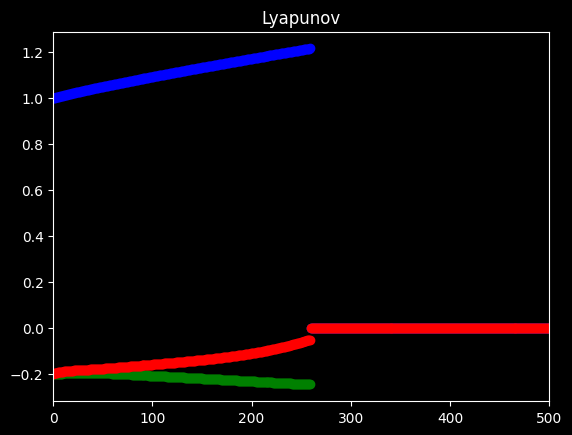

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
plt.rcParams["figure.autolayout"] = True

#a_seq = a_seq.detach().numpy()
#b_seq = b_seq.detach().numpy()

y = Lyapunov_seq.detach().numpy()
x = np.arange(0,epochs,1)

plt.scatter(x,b_seq,color = "green")
plt.scatter(x,a_seq,color = "blue")
#plt.plot(a_seq*130,b_seq,color = "white")


ax1.set_xlim([0,500])
plt.title("Lyapunov")
plt.scatter(x, y, color="red",label="Lyapunov Exponent")

plt.show()

In [ ]:
steps=10000
X,Y = henon_attractor_iters(steps,a = a_seq[lim],b = b_seq[lim])

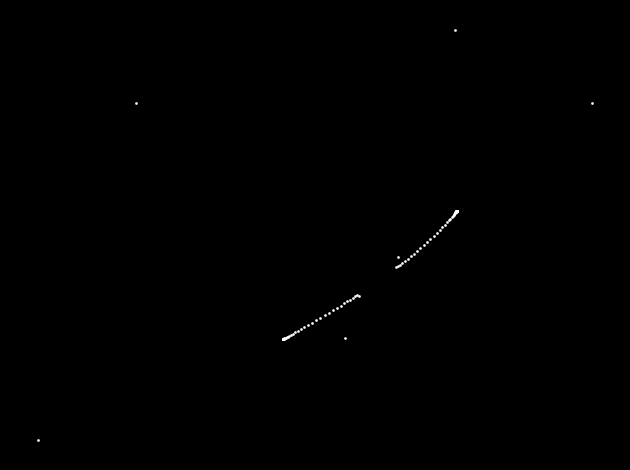

In [ ]:
#fig.set_facecolor("#f4f0e8")
#plt.rcParams["figure.figsize"] = [9, 6]
#plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots()
plt.style.use('dark_background')
plt.rcParams["figure.autolayout"] = False

plt.plot(X, Y,'.', color='white', alpha = 0.9, markersize=2,)

plt.axis('off')
plt.show()
plt.close()

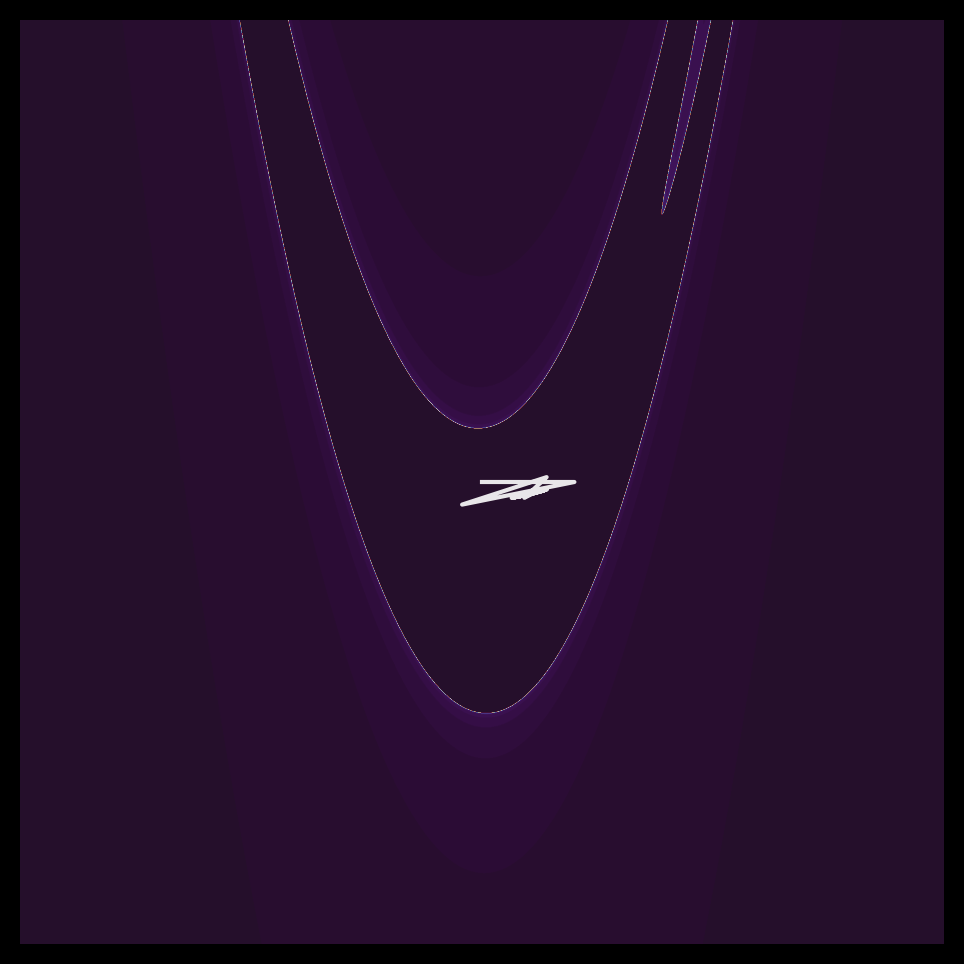

In [ ]:
X,Y = henon_attractor_iters(steps=100000,a=a_seq[lim],b=b_seq[lim])
plt.rcParams["figure.figsize"] = [9,6]
plt.rcParams['figure.dpi'] = 200

plt.plot(X, Y, '-', color='white', alpha = 0.9, markersize =1.1)
plt.imshow(henon_boundary(70, a=1.05, b=0.3), extent=[-5,5,-5,5], cmap='twilight_shifted', alpha=0.8)
plt.axis('off')

plt.show()
plt.close()